# Drift correction

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [1]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [27]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-1
    end = np.max(t2)+1
    idx = (t1>=start)*(t1<=end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=18)
        
        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        print(thetimes[0:4])
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-1], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [3]:
# A function to find matching timestamps

def findtimes(highrestimes, lowrestimes):
    
    # interpolate times to match resolutions
    
    
    
    
    # 
    i=0
    timeindexes = []
    for thistime in gem2dayseconds:
        thistimeindex = np.where(timesteps[:] == thistime)
        if thistimeindex[0].size > 0:
            timeindexes.append(thistimeindex[0])
    
    

In [28]:
posfile = "/mnt/documents/Q1/P7-17032021/GPSdata/station1-base3/rtklib-kppp/Q1-P7-day1-17032021.pos"

In [29]:
this = pd.read_csv(posfile, skiprows = 18)

In [30]:
this.keys()

Index(['%  UTC                 ', ' latitude(deg)', 'longitude(deg)',
       ' height(m)', '  Q', ' ns', '  sdn(m)', '  sde(m)', '  sdu(m)',
       ' sdne(m)', ' sdeu(m)', ' sdun(m)', 'age(s)', ' ratio'],
      dtype='object')

In [31]:
plon, plat, ptimes = readbasegps(posfile)

['2021/03/17 06:03:54.000' '2021/03/17 06:03:54.500'
 '2021/03/17 06:03:55.000' '2021/03/17 06:03:55.500']


In [240]:
glon, glat, gtimes = readbasegps(gpxfile)

/mnt/documents/Q1/P6-14032021/gnss/Tracker1_St/Day1/Current.gpx


In [241]:
gtimes[0]

datetime.datetime(2021, 3, 14, 15, 47, 32)

In [242]:
gtimes[-1]

datetime.datetime(2021, 3, 14, 16, 53, 38)

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to UTM (or other projected system measured in meters)

In [32]:
## get the UTM zone
utmzone=getutm(plon[0], plat[0])
utmzone

[CRSInfo(auth_name='EPSG', code='32635', name='WGS 84 / UTM zone 35N', type=<PJType.PROJECTED_CRS: 'PROJECTED_CRS'>, deprecated=False, area_of_use=AreaOfUse(west=24.0, south=0.0, east=30.0, north=84.0, name='Between 24°E and 30°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Bulgaria. Central African Republic. Democratic Republic of the Congo (Zaire). Egypt. Estonia. Finland. Greece. Latvia. Lesotho. Libya. Lithuania. Moldova. Norway. Poland. Romania. Russian Federation. Sudan. Svalbard. Turkey. Uganda. Ukraine.'), projection_method_name='Transverse Mercator'), CRSInfo(auth_name='EPSG', code='32636', name='WGS 84 / UTM zone 36N', type=<PJType.PROJECTED_CRS: 'PROJECTED_CRS'>, deprecated=False, area_of_use=AreaOfUse(west=30.0, south=0.0, east=36.0, north=84.0, name='Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Fe

'32635'

In [33]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [34]:
gnssutm = thetransform.transform(plat, plon)
gnssutm = np.array(gnssutm)

## Convert time to seconds-of-day

**check time zones! Use UTC.**

In [36]:
gnssdayseconds=[]
for thetime in ptimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))

In [37]:
gnssdayseconds[0:5]

[21834.0, 21834.5, 21835.0, 21835.5, 21836.0]

## Load  GEM2 data to be drift corrected

In [38]:
gem2inputfile = "/mnt/documents/Q1/P7-17032021/GEM2/Q1-P7-transect-17032021-gem2-531-channel-thickness.csv"

In [39]:
gem2data = pd.read_csv(gem2inputfile)

In [40]:
gem2data

time   record_id   longitude   latitude   xc  \
0      2021-03-17T06:53:57.328125           0    0.000000   0.000000  0.0   
1      2021-03-17T06:53:57.425781           1    0.000000   0.000000  0.0   
2      2021-03-17T06:53:57.527343           2   29.974997  81.995123  0.0   
3      2021-03-17T06:53:57.625000           3   29.974996  81.995123  0.0   
4      2021-03-17T06:53:57.726562           4   29.974996  81.995123  0.0   
...                           ...         ...         ...        ...  ...   
18371  2021-03-17T07:42:42.773437       18371    0.000000   0.000000  0.0   
18372  2021-03-17T07:42:42.875000       18372    0.000000   0.000000  0.0   
18373  2021-03-17T07:42:42.976562       18373    0.000000   0.000000  0.0   
18374  2021-03-17T07:42:43.078125       18374    0.000000   0.000000  0.0   
18375  2021-03-17T07:42:43.179687       18375    0.000000   0.000000  0.0   

        yc  f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0      0.0           nan          0.478           0.526           0.492   
1      0.0           nan          0.495           0.573           0.496   
2      0.0           nan          0.515           0.614           0.484   
3      0.0           nan          0.501           0.509           0.490   
4      0.0           nan          0.488           0.432           0.491   
...    ...           ...            ...             ...             ...   
18371  0.0           nan          0.425           0.638           0.493   
18372  0.0           nan          0.452           0.588           0.488   
18373  0.0           nan          0.481           0.510           0.489   
18374  0.0           nan          0.487           0.457           0.487   
18375  0.0           nan          0.513           0.407           0.483   

        f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
0               0.547           0.481            0.526            0.418   
1               0.536           0.481            0.526            0.418   
2               0.530           0.483            0.525            0.419   
3               0.531           0.485            0.527            0.419   
4               0.529           0.479            0.527            0.419   
...               ...             ...              ...              ...   
18371           0.530           0.483            0.525            0.417   
18372           0.537           0.475            0.526            0.417   
18373           0.541           0.476            0.526            0.414   
18374           0.527           0.484            0.526            0.416   
18375           0.528           0.482            0.525            0.419   

        f63030Hz_hcp_i  f63030Hz_hcp_q  
0                0.506             nan  
1                0.505             nan  
2                0.505             nan  
3                0.505             nan  
4                0.506             nan  
...                ...             ...  
18371            0.507             nan  
18372            0.507             nan  
18373            0.507             nan  
18374            0.507             nan  
18375            0.507             nan  

[18376 rows x 16 columns]

In [41]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [42]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [43]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [44]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

Text(0.5, 1.0, 'uncorrected drift track - local coordinates')

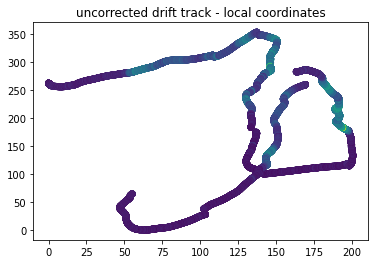

In [45]:
plt.scatter(gem2easting-np.min(gem2easting), gem2northing-min(gem2northing), c = f1530hz_hcp_i)
plt.title("uncorrected drift track - local coordinates")

In [46]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [47]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [48]:
len(gem2dayseconds)

18057

In [49]:
gnssdayseconds

[21834.0,
 21834.5,
 21835.0,
 21835.5,
 21836.0,
 21836.5,
 21837.0,
 21837.5,
 21838.0,
 21838.5,
 21839.0,
 21839.5,
 21840.0,
 21840.5,
 21841.0,
 21841.5,
 21842.0,
 21842.5,
 21843.0,
 21843.5,
 21844.0,
 21844.5,
 21845.0,
 21845.5,
 21846.0,
 21846.5,
 21847.0,
 21847.5,
 21848.0,
 21848.5,
 21849.0,
 21849.5,
 21850.0,
 21850.5,
 21851.0,
 21851.5,
 21852.0,
 21852.5,
 21853.0,
 21853.5,
 21854.0,
 21854.5,
 21855.0,
 21855.5,
 21856.0,
 21856.5,
 21857.0,
 21857.5,
 21858.0,
 21858.5,
 21859.0,
 21859.5,
 21860.0,
 21860.5,
 21861.0,
 21861.5,
 21862.0,
 21862.5,
 21863.0,
 21863.5,
 21864.0,
 21864.5,
 21865.0,
 21865.5,
 21866.0,
 21866.5,
 21867.0,
 21867.5,
 21868.0,
 21868.5,
 21869.0,
 21869.5,
 21870.0,
 21870.5,
 21871.0,
 21871.5,
 21872.0,
 21872.5,
 21873.0,
 21873.5,
 21874.0,
 21874.5,
 21875.0,
 21875.5,
 21876.0,
 21876.5,
 21877.0,
 21877.5,
 21878.0,
 21878.5,
 21879.0,
 21879.5,
 21880.0,
 21880.5,
 21881.0,
 21881.5,
 21882.0,
 21882.5,
 21883.0,
 21883.5,


In [50]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

In [51]:
gnss_trimmedtime = np.squeeze(gnss_trimmedtime)

In [53]:
gnss_trimmedtime[0]

6006

In [54]:
gnssutm = np.array(gnssutm)

In [55]:
gnssutm[0][gnss_trimmedtime]

array([838903.42803644, 838903.43926615, 838903.45096054, ...,
       838952.58881804, 838952.58976961, 838952.59431384])

In [56]:
gnssdayseconds = np.array(gnssdayseconds)

In [57]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [58]:
trimmedtime.size

5852

In [59]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [60]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 4min 12s, sys: 34 ms, total: 4min 12s
Wall time: 4min 12s


In [61]:
len(timeindexes)

18057

In [62]:
len(gem2easting)

18057

In [63]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

In [64]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [65]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [66]:
local_gem2_east.size

18057

In [67]:
world_gem2_east = local_gem2_east + gnssutm[0][0]
world_gem2_north = local_gem2_north + gnssutm[1][0]

In [68]:
world_gem2_east.size

18057

In [69]:
gnss_gem2_match_eastings[0]

838903.4399046657

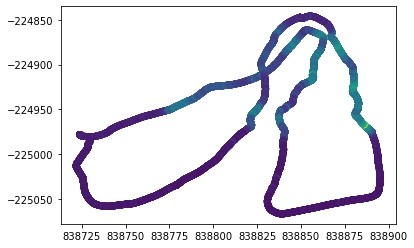

In [70]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i)

In [71]:
gem2_header = """AeN Q1 2021 P7 GEM2 measurements
GEM2-531 electromagnetic induction sounder
17 March 2021\nAdam Steer / Dmitry Divine
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [72]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [73]:
gem2out = gem2data.copy()

In [74]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [75]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [76]:
gem2out.insert(2, "easting", world_gem2_east)

In [77]:
gem2out.insert(3, "northing", world_gem2_north)

In [78]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [79]:
gem2_output = "/mnt/documents/Q1/P7-17032021/GEM2/GEM2data-driftcorrected.csv"

In [80]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [81]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Using the old NP magnaprobe, 1024 weeks need to be added to the timestamp. This is because the internal GPS processing software doesn't know about the GPS week rollover in 2019 - so it is 1024 weeks out of sync, and has been since April 6 2019.

In [113]:
magnaprobeinputfile = "/mnt/documents/Q1/P7-17032021/magnaprobe/NPI40.dat"


In [114]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [115]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [116]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values
mprawtimes = mprawtimes
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [117]:
weekdelta = timedelta(weeks=1024)

In [118]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [119]:
mptimes

array(['06:50:55.05', '06:50:58.52', '06:50:59.74', ..., '07:45:11.28',
       '07:45:12.39', '07:45:13.43'], dtype='<U11')

In [120]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [121]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

In [122]:
gnssdayseconds = np.array(gnssdayseconds)

In [123]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [124]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [125]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 124 ms, sys: 2 µs, total: 124 ms
Wall time: 124 ms


In [126]:
len(timeindexes)

1613

In [127]:
len(mp_dayseconds)

1613

In [128]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [129]:
mplatddd = mpdata["latitude_a"].values + (mpdata["latitude_b"].values / 60)
mplonddd = mpdata["Longitude_a"].values + (mpdata["Longitude_b"].values / 60)

In [130]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [131]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

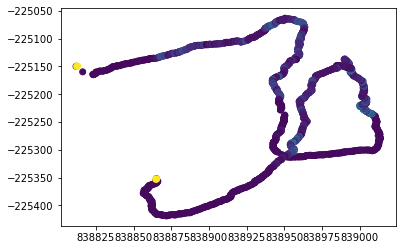

In [132]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"])

Do the drift correction to local coordinates

In [133]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

In [134]:
len(mpeasting)

1613

In [135]:
len(gnss_mp_match_eastings)

1613

Convert back to world coordinates

In [136]:
world_mp_east = local_mp_east + gnssutm[0][0]
world_mp_north = local_mp_north + gnssutm[1][0]

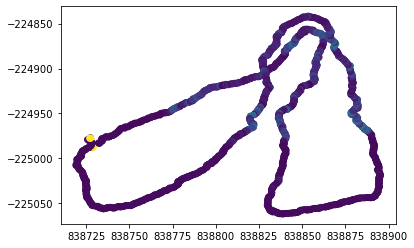

In [137]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"])

Export data to CSV

In [138]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdaysfixed[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [139]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"]/100   })

In [140]:
mp_output = "/mnt/documents/Q1/P7-17032021/magnaprobe/MPdata-driftcorrected-datefixed.csv"

In [141]:
mp_header = """AeN Q1 2021 P7 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
17 March 2021\nAdam Steer / Dmitry Divine
Date corrected: adding 1024 weeks to instrument timestamps to account for 2019 GPS week rollover
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [142]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [143]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

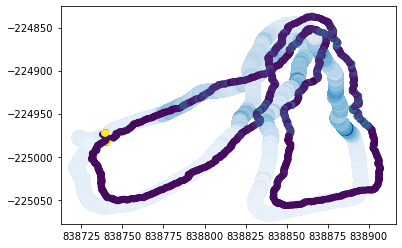

In [144]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east+12, world_mp_north+5, c = mpdata["DepthCm"]/100)

## Load camera centers to be drift corrected

In [154]:
cameracentrefile = "/mnt/documents/ANAFI-USA/AeNQ1/17march2021-AeNQ1-P7/cameracentres.csv"

In [155]:
cameradata = pd.read_csv(cameracentrefile)

In [156]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [157]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [158]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

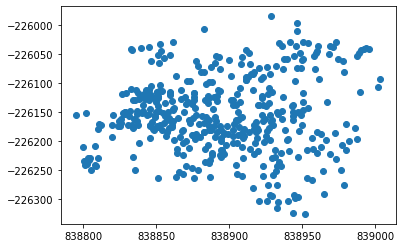

In [159]:
plt.scatter(cameraeasting, cameranorthing)

In [160]:
cameradata

SourceFile     DateTimeOriginal  SubSecTimeOriginal  GPSLatitude  \
0    ./jpg/P0611183.JPG  2021:03:17 13:01:29                 389    81.992654   
1    ./jpg/P0611184.JPG  2021:03:17 13:01:32                 922    81.992707   
2    ./jpg/P0611185.JPG  2021:03:17 13:01:35                 990    81.992755   
3    ./jpg/P0611186.JPG  2021:03:17 13:01:39                 219    81.992811   
4    ./jpg/P0611187.JPG  2021:03:17 13:01:41                 852    81.992799   
..                  ...                  ...                 ...          ...   
431  ./jpg/P0621614.JPG  2021:03:17 13:32:45                 418    81.992617   
432  ./jpg/P0621615.JPG  2021:03:17 13:32:48                 579    81.992604   
433  ./jpg/P0621616.JPG  2021:03:17 13:32:53                  93    81.992548   
434  ./jpg/P0621617.JPG  2021:03:17 13:33:04                 327    81.992544   
435  ./jpg/P0631618.JPG  2021:03:17 13:34:32                 888    81.992552   

     GPSLongitude  GPSAltitude  AboveGroundAltitude  GPSXYAccuracy  \
0       29.919511    40.513985            44.150120       0.601082   
1       29.919139    45.468327            48.729458       0.714493   
2       29.918875    49.005894            52.045437       0.686222   
3       29.918631    47.919521            54.491203       0.856329   
4       29.918595    44.050735            50.331032       0.863713   
..            ...          ...                  ...            ...   
431     29.906023     6.037430            10.489107       1.167776   
432     29.905969     4.106359             8.558559       1.167776   
433     29.905547     1.771702             6.442217       1.040625   
434     29.905464     0.062942             2.814120       0.708378   
435     29.904900     2.595972             0.000000       0.994887   

     GPSZAccuracy  CameraYawDegree  CameraPitchDegree  
0             1.3        46.606819         -73.005196  
1             1.5        46.737198         -73.007332  
2             1.4        33.436649         -73.019493  
3             1.7        43.500019         -73.029274  
4             1.7        30.529556         -68.890862  
..            ...              ...                ...  
431           2.2        34.563965          -0.264291  
432           2.2        33.326576           0.012847  
433           2.0        33.331570          -0.000128  
434           1.5        32.539547           0.272345  
435           2.2        68.532097           0.709251  

[436 rows x 11 columns]

In [161]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [162]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [163]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

[0.389, 0.922, 0.99, 0.219, 0.852]

In [164]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-3)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1

In [165]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, cam_dayseconds)

In [166]:
gnssdayseconds = np.array(gnssdayseconds)

In [167]:
len(cam_dayseconds)

436

In [169]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [170]:
min(cam_dayseconds)

36060.219

In [171]:
max(cam_dayseconds)

38040.888

In [172]:
min(gnssdayseconds)

21834.0

In [173]:
max(gnssdayseconds)

49082.5

In [174]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.001)
timesteps = np.round(timesteps, 3)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [175]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 325 ms, sys: 0 ns, total: 325 ms
Wall time: 324 ms


In [176]:
gnss_cam_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(interp_north[timeindexes])

In [177]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [178]:
local_cam_east[0]

-62.056869545252994

In [179]:
local_gem2_east[0]

-92.05698471621145

In [180]:
local_mp_east[0]

-87.46264143602457

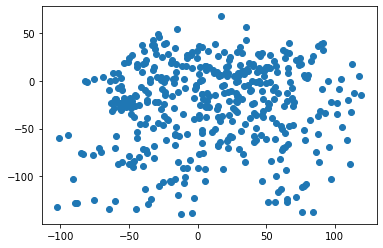

In [181]:
plt.scatter(local_cam_east, local_cam_north)

In [182]:
plt.scatter(gnssutm_d2[0], gnssutm[1])
#plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(gnss_gem2_match_eastings,gnss_gem2_match_northings, label = "gem2")
plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings, label = "MP")

plt.legend()


NameError: name 'gnssutm_d2' is not defined

In [185]:
world_cam_east = local_cam_east + gnssutm[0][0]
world_cam_north = local_cam_north + gnssutm[1][0]

In [186]:
world_cam_east[0]

838753.8017793518

In [187]:
world_gem2_east[0]

838723.8016641808

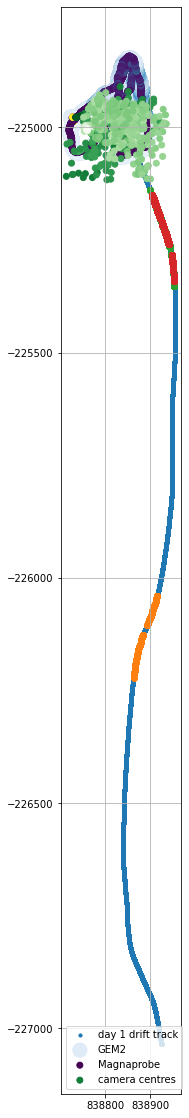

In [188]:
fig = plt.figure(figsize=(20,20))

plt.scatter(gnssutm[0],gnssutm[1], s = 10, label = 'day 1 drift track')
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("/mnt/documents/Q1/P6-14032021/driftracks.png")

In [189]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [190]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [191]:
cam_out = cameradata.copy()

In [192]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [193]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [194]:
mp_output_exiftool = "/mnt/documents/ANAFI-USA/AeNQ1/17march2021-AeNQ1-P7/driftcorrected-for-exiftool.csv"

In [195]:
cam_out.to_csv(mp_output_exiftool, index=False)

In [196]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

0.003413613428051576

In [197]:
cam_out['GPSLatitude'][0]

81.99606744673365

cam_o

In [198]:
cam_out_hag = cam_out.copy()

In [199]:
cam_out_hag["GPSAltitude"] = cam_out_hag["AboveGroundAltitude"]

In [200]:
cam_out_hag.drop(columns = ["AboveGroundAltitude"], inplace = True)

In [201]:
cam_output_exiftool_hag = "/mnt/documents/ANAFI-USA/AeNQ1/17march2021-AeNQ1-P7/driftcorrected-for-exiftool-HAG.csv"

In [202]:
cam_out_hag.to_csv(cam_output_exiftool_hag, index=False)